In [1]:
import pandas as pd 
import numpy as np 
def read_market_data(fileName):
    df = pd.read_csv(fileName).fillna("")
    cols = df.columns.tolist()[0].split(';')
    fin = pd.DataFrame(df.iloc[:,0].apply(lambda x: x.split(';')).values.tolist(),columns= cols)
    to_float_cols = ['day','timestamp','bid_price_1','bid_volume_1','bid_price_2','bid_volume_2','bid_price_3','bid_volume_3','ask_price_1','ask_volume_1','ask_price_2','ask_volume_2','ask_price_3','ask_volume_3','mid_price','profit_and_loss']
    fin[to_float_cols] =  fin[to_float_cols].applymap(lambda x: float(x) if x != '' else '')
    # fin = add_spread_data(fin)
    return fin

def add_percentage_to_cols(df,cols):
    df = df.copy()
    for col in cols: 
        df[col+'_pct'] = df[col].pct_change().cumsum()
    return df 
def calculate_smart_values(df):
    df = df.copy()
    df['average_buy_price'] = df.apply(lambda x: np.mean([i for i in x[['bid_price_1','bid_price_2','bid_price_3']].tolist() if i!='']),axis = 1)
    df['average_sell_price'] = df.apply(lambda x: np.mean([i for i in x[['ask_price_1','ask_price_2','ask_price_3']].tolist() if i!='']),axis = 1)
    df['buy_quantity'] = df.apply(lambda x: np.sum([i for i in x[['bid_volume_1','bid_volume_2','bid_volume_3']].tolist() if i!='']),axis = 1)
    df['sell_quantity'] = df.apply(lambda x: np.sum([i for i in x[['ask_volume_1','ask_volume_2','ask_volume_3']].tolist() if i!='']),axis = 1)
    df['smart_price'] = df.apply(lambda x: (((x['average_buy_price']* x['sell_quantity'])+(x['average_sell_price']*x['buy_quantity']))/(x['buy_quantity']+x['sell_quantity']) ),axis = 1)
    return df

tgt_cols =  ['bid_price_1','bid_price_2','bid_price_3','ask_price_1','ask_price_2','ask_price_3','mid_price']
# coco = add_percentage_to_cols(coco, tgt_cols)
# pina  = add_percentage_to_cols(pina, tgt_cols)
berry = read_market_data(r'..\00_Island_Data_Bottle\data_cleanup\berries_orderbook_data_all.csv')
# banana = read_market_data(r'..\00_Island_Data_Bottle\data_cleanup\bananas_orderbook_data_all.csv')
berry[tgt_cols] = berry[tgt_cols].applymap(lambda x: '' if x == 0 else x )
# banana[tgt_cols] = banana[tgt_cols].applymap(lambda x: '' if x == 0 else x )
# banana = calculate_smart_values(banana)
berry = calculate_smart_values(berry)

In [231]:
from statsmodels.tsa.seasonal import seasonal_decompose
resm=seasonal_decompose(berry['mid_price'], model='multiplicable', period=10000)

In [66]:
dolphin = read_market_data(r'..\00_Island_Data_Bottle\data_cleanup\dolphin_sightings_orderbook_data_all.csv')
gear = read_market_data(r'..\00_Island_Data_Bottle\data_cleanup\diving_gear_orderbook_data_all.csv')
# cols_to_plot = [i for i in gear.columns.tolist() if 'price' in i  ]
# dolphin[tgt_cols] = berry[tgt_cols].applymap(lambda x: '' if x == 0 else x )
# gear[tgt_cols] = banana[tgt_cols].applymap(lambda x: '' if x == 0 else x )

In [67]:
res = pd.concat([resm.trend,resm.seasonal],axis = 1)
res['combined'] = res['seasonal']* res['trend']
res = pd.concat([pd.DataFrame(resm.resid.dropna()),res],axis = 1)
res['combined'] = res['combined'] * res['resid']

In [81]:
seasonality = resm.seasonal[:10000].values.tolist()

<Axes: >

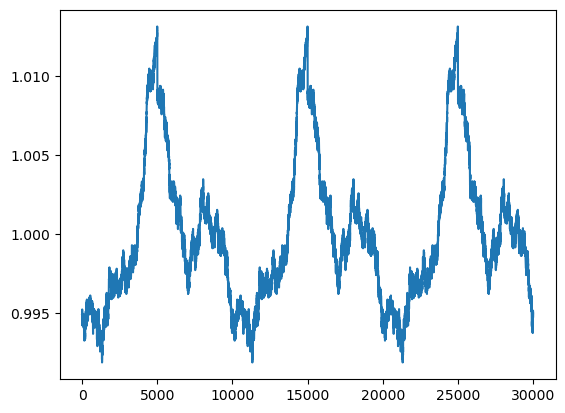

In [94]:
resm.seasonal.plot()

In [298]:
slope

-0.04272128289681658

In [297]:
x,y = np.arange(1,501),bt['trend'].iloc[0:500]
slope, intercept = np.polyfit(x,y,1)
abline_values = [slope * i + intercept for i in np.arange(501,1001)]

c:\ProgramData\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<Axes: >

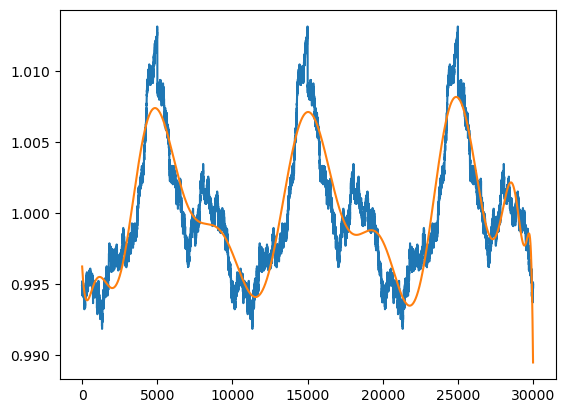

In [289]:
poly = np.polyfit(bt.index,bt['seasonal'], deg=50)
eval = np.polyval(poly, bt.index)
bt['seasonal'].plot()
pd.Series(eval).plot()

In [21]:
berry_mean_diff = abs(berry['mid_price'].diff().dropna()).mean()

In [33]:
bt = pd.concat([pd.DataFrame(resm.seasonal),berry['mid_price']],axis = 1)
bt['trend'] = bt[['seasonal','mid_price']].apply(lambda x: x['mid_price']/x['seasonal'],axis = 1)

In [436]:

# mean_diff = 0.027953949579832396
# def backtest(lookback,forecast_x ):
# lookback = 500 
# forecast_x = 100
def backtest(lookback,forecast_x):
    prev_position = 0 
    predictions = dict()
    bt[['pct_pnl','pnl_value','position']] = 0
    for i,row in bt.iterrows():
        if lookback < i-1:
            try:
                curr_value = row['mid_price']
                prev_values = bt['mid_price'][i-lookback:i]
                slope, intercept = np.polyfit(np.arange(0,len(prev_values)),prev_values,1)
                future_value = (slope * (len(prev_values)+forecast_x)) + intercept
                future_value = future_value * bt['seasonal'].iloc[i+forecast_x]
                predictions[i-1+forecast_x] = future_value
                if slope > 0:
                    print(i-1,'long',curr_value, future_value,slope,'future')
                    bt.at[i-1,'position'] = 1
                    prev_position = 1
                elif slope <0: 
                    print(i-1,'short',curr_value, future_value,slope,'curr')
                    bt.at[i-1,'position'] = -1
                    prev_position = -1
                else:
                    bt.at[i-1,'position'] = bt['position'].iloc[i-1]
            except:
                bt.at[i-1,'position'] = bt['position'].iloc[i-1]
    bt['pct_pnl'] = bt['pct']*bt['position']
    bt['pnl_value'] = bt['pct_pnl'] * bt['mid_price']
    bt['cumpnl'] = bt['pnl_value'].cumsum()
    print(bt['pnl_value'].cumsum().values[-1])
    return bt

In [440]:
p = backtest(250,500)

251 short 3991.5 3944.358855883961 -0.04968636298181166 curr
252 short 3990.5 3944.137208717798 -0.05000201603225341 curr
253 short 3990.5 3943.8555149832423 -0.05040791052656323 curr
254 short 3989.5 3943.8893909595513 -0.05071127538040978 curr
255 short 3989.5 3942.6032772055714 -0.05110334565353979 curr
256 short 3990.0 3943.8435276760215 -0.05148773580376922 curr
257 short 3990.0 3943.659693788453 -0.05172025152401808 curr
258 short 3989.5 3943.484505635141 -0.051944703115250186 curr
259 short 3989.5 3942.8307692109865 -0.05211251380022377 curr
260 short 3987.5 3942.6833549318935 -0.052271108337734545 curr
261 short 3987.5 3941.3468143895016 -0.05270810732971652 curr
262 short 3987.5 3941.343711708711 -0.05303873661979372 curr
263 short 3987.5 3939.9154918040367 -0.053647770364327725 curr
264 short 3987.5 3940.8764658570813 -0.0540555848893591 curr
265 short 3987.5 3940.835469179447 -0.054453415254647364 curr
266 short 3987.5 3941.255803399089 -0.054937647002351 curr
267 short 3986

<Axes: >

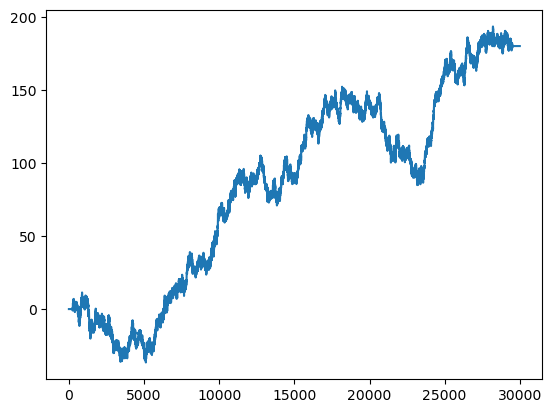

In [443]:
p['cumpnl'].plot()

<Axes: >

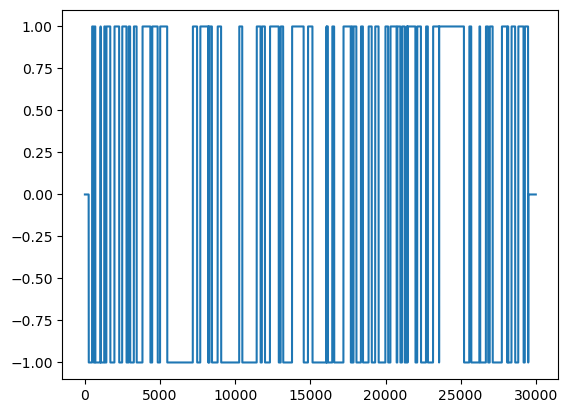

In [444]:
p['position'].plot()

In [180]:
bt['pct'] = bt['mid_price'].pct_change()
bt['pct_pnl'] = bt['pct']*bt['position']
bt['pnl_value'] = bt['pct_pnl']*bt['mid_price']

<Axes: >

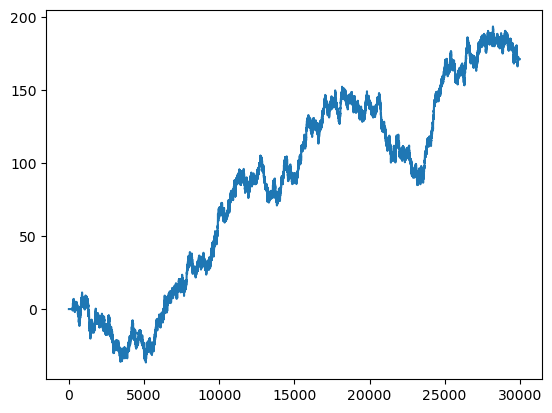

In [439]:
p['cumpnl'].plot()

<Axes: >

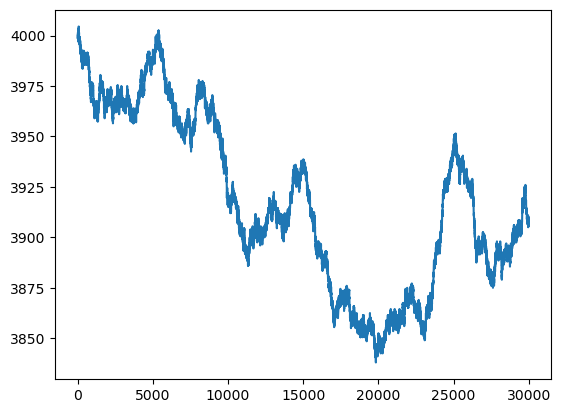

In [183]:
bt['mid_price'].plot()

In [43]:
from sklearn.metrics import r2_score
for i in range(1,500):
    bt['ma_'+str(i)] = bt['mid_price'].rolling(window = i).mean()

In [59]:
scores = []
for i in range(1,500):
    temp = pd.DataFrame(bt['ma_'+str(i)]).join(pd.DataFrame(bt['mid_price'])).dropna()
    score = r2_score(temp.iloc[:,0],temp.iloc[:,1])
    scores.append(['ma_'+str(i),score])
    

In [ ]:
sorted(scores, key = lambda x: x[-1], reverse = False)

In [106]:
temp = pd.DataFrame(bt['ma_'+str(250)]).join(pd.DataFrame(bt['mid_price'])).dropna()

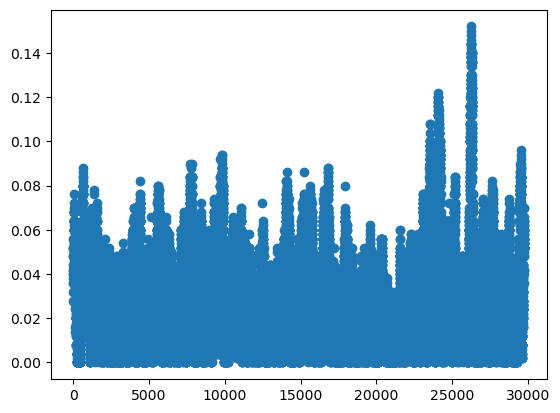

In [109]:
plt_size = 250
plt.scatter(np.arange(0,len(abs(bt['ma_'+str(plt_size)].diff().dropna()))),abs(bt['ma_'+str(plt_size)].diff().dropna()))

In [112]:
abs(bt['ma_'+str(plt_size)].diff().dropna()).mean()


0.027953949579832396